# 0 Set paths, devices, etc.

In [ ]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import h5py
import random

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import  PreTrainedTokenizerFast

In [ ]:
# notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = 'drive/MyDrive/neuro2voc/task_1/data/'
# data_dir = '/home/zubat/Fei/Task_1/outputs/'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



# 1 Load the basic tokenizer

In [57]:
for_tokenizer_dir = data_dir+"3_train_tokenizer/"
tokenizer_dir = data_dir+"4_tokenizer/"

In [58]:
# define special tokens
num_neurons = 75
special_tokens_temporal =  ["<|start|>", "<|end|>", "<|>"]
# for i in range(num_neurons):
#     special_tokens_temporal.extend([f"<|s_{i}|>", f"<|e_{i}|>"])

special_tokens_spatial = ["<|start|>", "<|end|>"]

# define vocab size, default: 30000
vocab_size = 100000

# instantiate the trainer
trainer_temporal = BpeTrainer(special_tokens = special_tokens_temporal, vocab_size=vocab_size)
trainer_spatial= BpeTrainer(special_tokens = special_tokens_spatial, vocab_size=vocab_size)

print(special_tokens_temporal)
print(special_tokens_spatial)

['<|start|>', '<|end|>', '<|>']
['<|start|>', '<|end|>']


# 2 Select your data

### 2.0 Select the h5py file you want to load

In [59]:
# mode = "temporal"
mode = "spatial"

batch_size = 1 # for spatial
# batch_size = 30
# batch_size = 60
# batch_size = 100
# batch_size = 120
# batch_size = 300
# batch_size = 600

file = "all"

# aggregated = True
aggregated = False

remove_zero = True
# remove_zero = False

In [60]:
if aggregated:
    path_data_for_tokenizer = f"{for_tokenizer_dir}{mode}_{file}_{batch_size}_aggregated.hdf5"
else:
    if remove_zero:
        path_data_for_tokenizer = f"{for_tokenizer_dir}{mode}_{file}_{batch_size}_rm0.hdf5"
    else:
        path_data_for_tokenizer = f"{for_tokenizer_dir}{mode}_{file}_{batch_size}.hdf5"


if mode == "spatial":
    tokenizer_batch_size = 1
else:
    tokenizer_batch_size = batch_size

print("Current reading data:")
print(f"Path: {path_data_for_tokenizer}")
print(f"Mode: {mode}")
print(f"Aggregation: {aggregated}")
print(f"Remove Zero: {remove_zero}")
print(f"Batch: {tokenizer_batch_size}")
print(f"File: {file}")

with h5py.File(path_data_for_tokenizer, 'r') as hdf5_file:
    # access the dataset
    hdf5_dataset = hdf5_file['data']

    # read the data from the dataset into a list
    data = [str(batch_data, 'utf-8') for batch_data in hdf5_dataset]

print("Reading finished.")

Current reading data:
Path: drive/MyDrive/neuro2voc/task_1/data/3_train_tokenizer/spatial_all_1_rm0.hdf5
Mode: spatial
Aggregation: False
Remove Zero: True
Batch: 1
File: all
Reading finished.


### 2.1 Data inspection

In [35]:
print(len(data[0]))
print(len(data))

75
7639653


In [22]:
type(data)

list

In [38]:
data[100]

'000000000000000000000000000000000000000000000000000000001000000000000000000'

### 2.2 Data division

In [62]:
data = data[:768821]
data

['000000000000000000000000000000000001000000000000000000000000000000000000000',
 '000100000000000000000000000000000000000000000000000000000000000000000000000',
 '000001000000000000000000000000000000000000000000000000000000000000000000000',
 '000000000000000000000000000000000000000000000000000000000000000010000000000',
 '000000000000000000000000000000000000000000000000000000000000010000000000000',
 '000010000000000000000000000000000000000000000000000000000000000000000000000',
 '000000000000000000000000000000000000010000000000000000000000000000000000010',
 '000100000000000000000000000000000000000000000000000000000000000000000000000',
 '000000000000000000000000000000000000000000000000000010000000000000000000000',
 '000000000000000000000000000000000000000000000000000000000000010000000000000',
 '100000000000000000000000000000000000000000000000000000000000000000000000000',
 '000000000000000000000000000000000000010000000000000000000000000000000000000',
 '00000100000000000000000000000000000000

In [68]:
data[-1]

'000100000000000000000000000000000000000000000000000000000000000000000000000'

# 3 Train tokenizer

In [64]:
if aggregated:
    tokenizer_name = f"{mode}_{file}_{batch_size}_aggregated"
else:
    if remove_zero:
        tokenizer_name = f"{mode}_{file}_{batch_size}_rm0"
    else:
        tokenizer_name = f"{mode}_{file}_{batch_size}"

if mode == "temporal":
    trainer=trainer_temporal
elif mode == "spatial":
    trainer=trainer_spatial

tokenizer_name

'spatial_all_1_rm0'

### 3.1 Build

In [65]:
# instantiate the tokenizer
tokenizer = Tokenizer(BPE())
# tokenizer.pre_tokenizer = Whitespace()

tokenizer.train_from_iterator(data, trainer=trainer)

# wrap it before saving it
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # unk_token="[UNK]",
    # mask_token="[MASK]",
    pad_token="[PAD]"
)

# tokenizer.save(data_dir+'tokenizer30')
wrapped_tokenizer.save_pretrained(tokenizer_dir+tokenizer_name)

('drive/MyDrive/neuro2voc/task_1/data/4_tokenizer/spatial_all_1_rm0/tokenizer_config.json',
 'drive/MyDrive/neuro2voc/task_1/data/4_tokenizer/spatial_all_1_rm0/special_tokens_map.json',
 'drive/MyDrive/neuro2voc/task_1/data/4_tokenizer/spatial_all_1_rm0/tokenizer.json')

### 3.2 Load

In [66]:
tokenizer = wrapped_tokenizer
# tokenizer = PreTrainedTokenizerFast.from_pretrained(output_dir+tensor_name)

In [67]:
tokenizer

PreTrainedTokenizerFast(name_or_path='', vocab_size=7106, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	7106: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

#### Sample sentence

In [ ]:
k = tokenizer.encode("<|start|>000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000001000000000000000000000000000000000000000000000000000000000000000000000<|end|>")
k

[0, 112, 15, 112, 112, 112, 112, 112, 112, 112, 13, 526, 1, 0, 1992, 1]

In [ ]:
tokenizer.encode("<|start|>000000000000000000000000000000000001000000000000000000000000000000000000000<|end|>")

[0, 151, 1]

In [ ]:
tokenizer.encode(data[0])

[12]

In [ ]:
data[0]

'000000000000000000000000000000000000000000000000000000000000000000000000000'

# 4 Load the data with labels

### 4.1 Load the data

In [30]:
# directory name
if mode == "temporal":
    data_labels_dir = data_dir+"3_data_labels_df_temporal/"
else:
    data_labels_dir = data_dir+"3_data_labels_df_spatial/"

# data labels name
if aggregated:
    data_labels_name = f"data_labels_{file}_{batch_size}_aggregated"
else:
    if remove_zero:
        data_labels_name = f"data_labels_{file}_{batch_size}_rm0"
    else:
        data_labels_name = f"{mode}_{file}_{batch_size}"

print(f"Reading data from {data_labels_dir}{data_labels_name}")

data_labels = pd.read_csv(data_labels_dir+data_labels_name+".csv")

Reading data from drive/MyDrive/neuro2voc/task_1/data/3_data_labels_df_spatial/data_labels_all_1_rm0


In [51]:
# truncate 'data' to the length of 'data_labels'
# because the previous code (code 3, part 3.2.2 remove zero for batch size 1)
# saved to hdf5 while initializing with the whole size
# aka a lot of empty space afterwards

# code only for drive/MyDrive/neuro2voc/task_1/data/3_data_labels_df_spatial/data_labels_all_1_rm0
data_truncated = data[:len(data_labels['labels'])]

# merge the truncated data with data_labels
merged_data = pd.DataFrame({
    'data': data_truncated,
    'labels': data_labels['labels']
})

print("Data merged successfully.")
print(merged_data.head())

Data merged successfully.
                                                data  labels
0  0000000000000000000000000000000000010000000000...       0
1  0001000000000000000000000000000000000000000000...       0
2  0000010000000000000000000000000000000000000000...       0
3  0000000000000000000000000000000000000000000000...       0
4  0000000000000000000000000000000000000000000000...       0


In [33]:
len(data_labels['labels'])

768821

In [34]:
len(data)

7639653

In [48]:
data[768819]

'000000000000000000000000000000000000000000100000000000000000000000000000000'

In [45]:
6870832 + 768821

7639653

### 4.2 Check distribution

In [53]:
frequency = merged_data.groupby(['data', 'labels']).size().reset_index(name='count')
most_frequent_pairs = frequency.sort_values(by='count', ascending=False)
print(most_frequent_pairs.head())

                                                   data  labels  count
7789  0000010000000000000000000000000000000000000000...       5  28208
7785  0000010000000000000000000000000000000000000000...       1  25972
8981  0001000000000000000000000000000000000000000000...       5  25447
8977  0001000000000000000000000000000000000000000000...       1  24259
7787  0000010000000000000000000000000000000000000000...       3  19650


In [54]:
most_frequent_pairs

,data,labels,count
7789,0000010000000000000000000000000000000000000000...,5,28208
7785,0000010000000000000000000000000000000000000000...,1,25972
8981,0001000000000000000000000000000000000000000000...,5,25447
8977,0001000000000000000000000000000000000000000000...,1,24259
7787,0000010000000000000000000000000000000000000000...,3,19650
...,...,...,...
7538,0000000010000000000000000000000100000000000000...,5,1
7537,0000000010000000000000000000000010000000000000...,5,1
7536,0000000010000000000000000000000010000000000000...,3,1
7535,0000000010000000000000000000000010000000000000...,0,1


from matplotlib import pyplot as plt
most_frequent_pairs['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
most_frequent_pairs['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
most_frequent_pairs.plot(kind='scatter', x='labels', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
most_frequent_pairs['labels'].plot(kind='line', figsize=(8, 4), title='labels')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
most_frequent_pairs['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

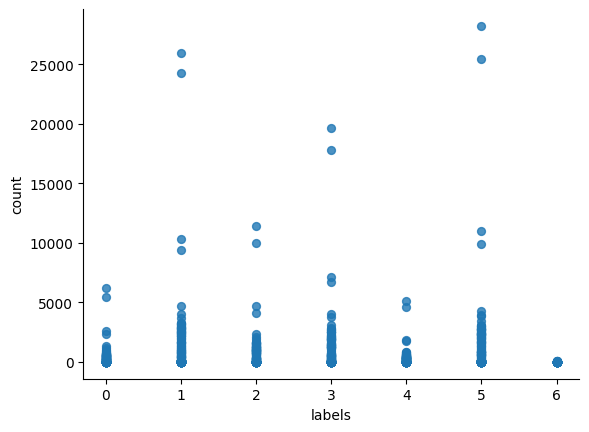

In [56]:
from matplotlib import pyplot as plt
most_frequent_pairs.plot(kind='scatter', x='labels', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

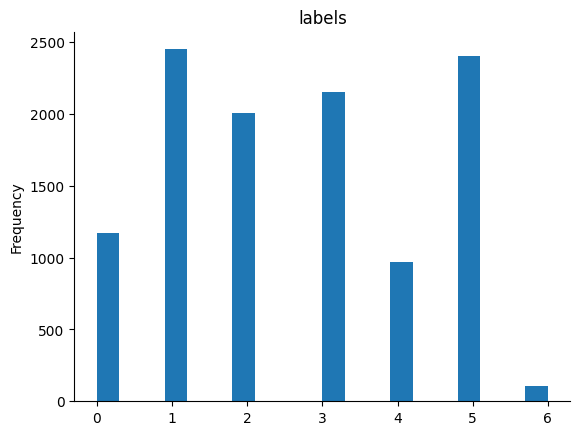

In [55]:
from matplotlib import pyplot as plt
most_frequent_pairs['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Archive: Select your data
this uses the output for the first part of the code 3. doesnt work!

### 2.0 Load Tensor Data

In [ ]:
# Select the tensor you want to load
# temporal:
tensor_name = 'temporal_30'
# tensor_name = 'temporal_60'
# tensor_name = 'temporal_120'

# spatial:
# tensor_name = 'spatial_30'
# tensor_name = 'spatial_60'
# tensor_name = 'spatial_120'

In [ ]:
current_tensor = torch.load(for_tokenizer_dir+tensor_name+'.pt')
print(current_tensor.shape)
print(len(current_tensor))
current_tensor

### 2.1 For Temporal Data

#### 2.1.1 Convert to strings directly without df
Doesnt work, takes 8 h

Result looks like this for text_data[i]

'tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)tensor(0, dtype=torch.int32)'

In [ ]:
text_data = []
for i in tqdm(range(len(current_tensor)), desc="Processing"):
    cur_str = ''.join(map(str, current_tensor[i]))
    text_data.append(cur_str)

In [ ]:
import h5py

byte_strings = np.array(text_data, dtype='S')
file_path = for_tokenizer_2_dir+tensor_name+'.hdf5'

with h5py.File(file_path, 'w') as hdf:
    hdf.create_dataset('data_for_tokenizer', data=byte_strings)

print(f"Data saved to {file_path}")

#### 2.1.2 Convert Tensors to df and concatenate
Skip, doesn't work

In [ ]:
# current_tensor_df = pd.DataFrame(current_tensor).astype("int")
# current_tensor_df

# column_names = list(range(30))
# column_names[:5]

# current_tensor_df['data'] = current_tensor_df[column_names].astype(str).agg(''.join, axis=1)
# current_tensor_df

#### 2.1.3 Reshape the tensor columns and convert to list
Skip, doesn't work

In [ ]:
# reshaped_tensor = current_tensor.view(-1, 30)

# current_tensor_to_list = reshaped_tensor.tolist()
# current_tensor_to_list

### 2.2 For Spatial Data